In [ ]:
import os
import requests

from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

# from openbabel import openbabel, pybel

# import rdkit
# from rdkit import Chem
# from rdkit.Chem.rdchem import HybridizationType
# from rdkit.Chem.rdchem import BondType as BT
# from rdkit.Chem import AllChem, rdmolfiles, rdmolops, rdMolTransforms

import optuna

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import pickle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import lightgbm as lgb
print(lgb.__version__)
print("GPU support available:", lgb.basic._LIB.LGBM_DatasetCreateFromFile)

4.5.0
GPU support available: <_FuncPtr object at 0x000001B9BEF90A00>


In [ ]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [ ]:
DATA_PATH = os.path.join(os.getcwd(),"data")

TRAIN_FILE = os.path.join(DATA_PATH, "train_with_more_features.csv")
TEST_FILE = os.path.join(DATA_PATH, "test_with_more_features.csv")
STRUCTURES_FOLDER = os.path.join(DATA_PATH, "structures")
STRUCTURES_FILE = os.path.join(DATA_PATH, "structures.csv")

# Model folder will be the subdirectory where we will store all of our different models and training/tuning iterations of them
MODEL_FOLDER = os.path.join(os.getcwd(),"models")

In [ ]:
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)

## 1. Preparing the data to work with LightGBM
### 1.1. Separating the

In [ ]:
X = train.drop(columns=["scalar_coupling_constant", "mol_name", "molecule_name"])
Y = train["scalar_coupling_constant"]

### 1.2 Transforming categorical variables

In [ ]:
X["hybridization_0"].unique()

array(['S'], dtype=object)

In [ ]:
X["hybridization_1"].unique()

array(['SP3', 'S', 'SP', 'SP2'], dtype=object)

In [ ]:
X = pd.get_dummies(X, columns=["atom_1"], drop_first=True)
X = pd.get_dummies(X, columns=["atom_0"])

J_type_encoder = LabelEncoder()
hybridization_encoder = LabelEncoder()

X["type"] = J_type_encoder.fit_transform(X["type"])
X["hybridization_1"] = hybridization_encoder.fit_transform(X["hybridization_1"])
X["hybridization_0"] = hybridization_encoder.transform(X["hybridization_0"])
X.shape[0]

4385261

### 1.3 Creating the validation set

In [ ]:
### Creating the validation set
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42)

### 1.4 Scaling the train and val sets

In [ ]:
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

numerical_columns = ["x_0", "y_0", "z_0", "AtomicMass_0", "Electronegativity_0", "AtomicRadius_0", "IonizationEnergy_0", "GasteigerCharge_0",
                     "x_1", "y_1", "z_1", "AtomicMass_1", "Electronegativity_1", "AtomicRadius_1", "IonizationEnergy_1", "GasteigerCharge_1",
                     "nuclear_distance", "xx_distance", "yy_distance", "zz_distance", "centroid_x", "centroid_y", "centroid_z", "pair_to_centroid_distance", "angle", "dihedral"]

X_train[numerical_columns] = feature_scaler.fit_transform(X_train[numerical_columns])
X_val[numerical_columns] = feature_scaler.transform(X_val[numerical_columns])

# Reshaping so we can fit the scaler
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val = target_scaler.transform(y_val.values.reshape(-1, 1))

# Flattening again to train LightGBM
y_train = y_train.ravel()
y_val = y_val.ravel()

In [ ]:
y_train.shape

(3946734,)

## 2. Modeling with LightGBM

We know from our EDA that the different J-coupling constants all have different statistical distribution depending on the type. Therefore, in order to evaluate the performance of LightGBM given our data preparation and feature generation, we'll follow the following approach:

1. We'll build a Reference model trained on all the available train_subset, without splitting the data by type of `scalar_coupling_constant`. The model params we'll be taken from the reference paper: doi.org/10.1002/ansa.202000180
2. We'll fine-tune our own model on all the available train_subset, in order to compare it to the benchmark set by 1.

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

In [ ]:
LGB_REFERENCE_PARAMS = {
    "objective": "regression",
    "metric": "mae",
    "num_leaves": 128,
    "min_child_samples": 79,
    "bagging_seed": 11,
    "learning_rate": 0.2,
    "reg_lambda": 0.3,
    "boosting_type": "gbdt",
    "subsample_freq": 1,
    "subsample": 0.9,
    "verbosity": -1,
    "reg_alpha": 0.1,
    "max_depth": 13,
    "colsample_bytree": 1.0,
    "device": "gpu"
}

### 2.1. Reference model

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

evals_result = {}

reference_model = lgb.train(
    params=LGB_REFERENCE_PARAMS,
    train_set=train_data,
    valid_sets=[train_data, val_data],
    callbacks=[lgb.record_evaluation(evals_result)]
)

reference_model.save_model(os.path.join(MODEL_FOLDER, "lightGBM_Reference_Model.txt"))

y_pred_1 = reference_model.predict(X_val, num_iteration=reference_model.best_iteration)
mae_reference_model = mean_absolute_error(y_val, y_pred_1)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

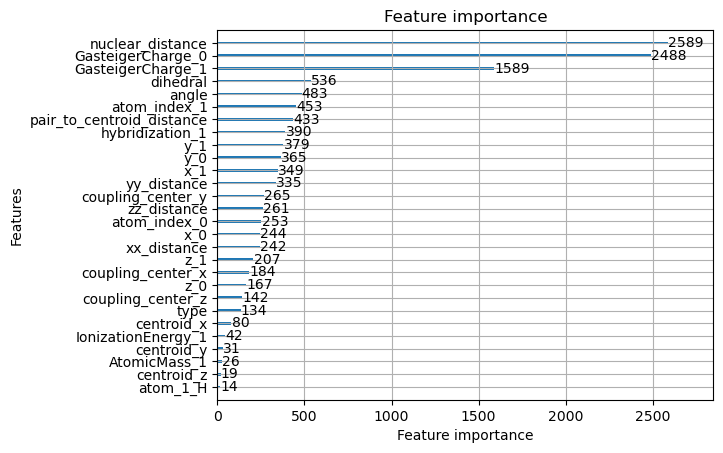

In [ ]:
lgb.plot_importance(reference_model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l1'>

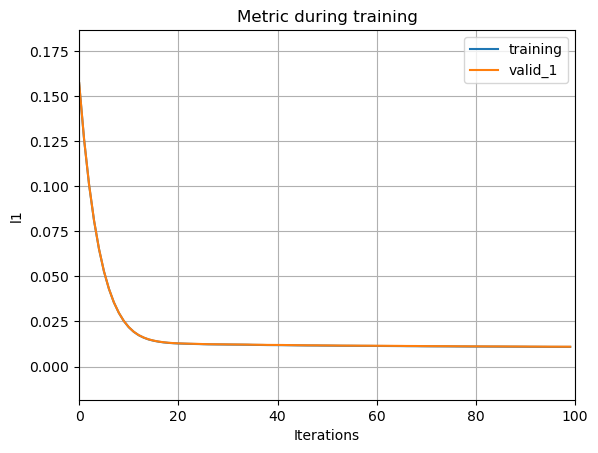

In [ ]:
lgb.plot_metric(evals_result)

In [ ]:
reference_model = lgb.Booster(model_file=os.path.join(MODEL_FOLDER, "lightGBM_Reference_Model.txt"))

y_reference_preds = reference_model.predict(X_val)

## 2.3. Fine-tuned_model

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_iterations': 1000,
        'early_stopping_round': 50,
        'learning_rate': 0.2,
        'num_leaves': trial.suggest_int('num_leaves', 16, 512, step=16),
        'max_depth': trial.suggest_int('max_depth', 2, 29), # Com a màxim, recorrer només 1 longitud màxima de molècula.
        'min_child_samples': trial.suggest_int('min_child_samples', 50, 160),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'subsample_freq': 1,
        "subsample": 0.9,
        "verbosity": -1,
        "reg_alpha": trial.suggest_float('reg_alpha', 0, 5),
        "colsample_bytree": 1.0,
        "device": "gpu",
        "feature_pre_filter": False
    }

    fine_tuned_model = lgb.train(params=params,
                      train_set=train_data,
                      valid_sets=[val_data],
                      callbacks=[lgb.early_stopping(50)])

    y_pred = fine_tuned_model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)

    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print(f"Best trial: {study.best_trial.number}")
print(f"Best value (MAE): {study.best_value}")
print(f"Best hyperparameters: {study.best_trial.params}")

[I 2024-12-17 22:58:34,607] A new study created in memory with name: no-name-8368d963-6c37-4f13-9c69-538e2b704f28


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:00:21,400] Trial 0 finished with value: 0.009742575871953516 and parameters: {'num_leaves': 240, 'max_depth': 7, 'min_child_samples': 138, 'reg_lambda': 1.9206167159550258, 'reg_alpha': 2.0368987451677163}. Best is trial 0 with value: 0.009742575871953516.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00844248


[I 2024-12-17 23:03:24,204] Trial 1 finished with value: 0.008442484033593248 and parameters: {'num_leaves': 416, 'max_depth': 10, 'min_child_samples': 77, 'reg_lambda': 0.7375367635204833, 'reg_alpha': 0.03158229564341031}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00880019


[I 2024-12-17 23:05:59,804] Trial 2 finished with value: 0.008800191244241837 and parameters: {'num_leaves': 256, 'max_depth': 18, 'min_child_samples': 149, 'reg_lambda': 4.95329078566566, 'reg_alpha': 1.6956073732010184}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:07:40,734] Trial 3 finished with value: 0.009172751309495764 and parameters: {'num_leaves': 144, 'max_depth': 8, 'min_child_samples': 77, 'reg_lambda': 1.5476092289556476, 'reg_alpha': 0.13923290533320032}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0089797


[I 2024-12-17 23:10:52,450] Trial 4 finished with value: 0.008979697429156533 and parameters: {'num_leaves': 368, 'max_depth': 10, 'min_child_samples': 97, 'reg_lambda': 0.12697542810517548, 'reg_alpha': 2.9907120775509135}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:12:32,640] Trial 5 finished with value: 0.00978461809854689 and parameters: {'num_leaves': 160, 'max_depth': 7, 'min_child_samples': 145, 'reg_lambda': 0.234669914344261, 'reg_alpha': 2.413377505392326}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00894304


[I 2024-12-17 23:15:00,051] Trial 6 finished with value: 0.008943042514973097 and parameters: {'num_leaves': 256, 'max_depth': 23, 'min_child_samples': 69, 'reg_lambda': 1.875031314013889, 'reg_alpha': 2.6470861208146235}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:18:18,503] Trial 7 finished with value: 0.00871196361493204 and parameters: {'num_leaves': 352, 'max_depth': 13, 'min_child_samples': 78, 'reg_lambda': 0.09434986145032964, 'reg_alpha': 2.1446263938703836}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00896973


[I 2024-12-17 23:22:01,699] Trial 8 finished with value: 0.00896973041549902 and parameters: {'num_leaves': 416, 'max_depth': 22, 'min_child_samples': 109, 'reg_lambda': 1.0763822963120095, 'reg_alpha': 4.497909723633998}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:22:41,340] Trial 9 finished with value: 0.01297670183036569 and parameters: {'num_leaves': 144, 'max_depth': 3, 'min_child_samples': 143, 'reg_lambda': 2.7860557973368887, 'reg_alpha': 1.5361746109981196}. Best is trial 1 with value: 0.008442484033593248.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:26:05,659] Trial 10 finished with value: 0.00805088912074015 and parameters: {'num_leaves': 496, 'max_depth': 27, 'min_child_samples': 50, 'reg_lambda': 3.103808115569226, 'reg_alpha': 0.14120073757146012}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:29:19,267] Trial 11 finished with value: 0.008078676934972542 and parameters: {'num_leaves': 512, 'max_depth': 29, 'min_child_samples': 50, 'reg_lambda': 3.6820318430770227, 'reg_alpha': 0.004764969862157416}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:33:03,645] Trial 12 finished with value: 0.008261195028637544 and parameters: {'num_leaves': 512, 'max_depth': 29, 'min_child_samples': 50, 'reg_lambda': 3.668728921737864, 'reg_alpha': 0.8159523638760491}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00827922


[I 2024-12-17 23:36:53,133] Trial 13 finished with value: 0.008279223529915211 and parameters: {'num_leaves': 512, 'max_depth': 29, 'min_child_samples': 50, 'reg_lambda': 3.5911590505489173, 'reg_alpha': 0.8635656938933141}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0104108


[I 2024-12-17 23:37:46,008] Trial 14 finished with value: 0.0104108168888777 and parameters: {'num_leaves': 32, 'max_depth': 25, 'min_child_samples': 61, 'reg_lambda': 3.3281737621919585, 'reg_alpha': 3.7270047067148937}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00829525


[I 2024-12-17 23:41:08,528] Trial 15 finished with value: 0.008295253737802738 and parameters: {'num_leaves': 448, 'max_depth': 18, 'min_child_samples': 94, 'reg_lambda': 4.522322993933754, 'reg_alpha': 0.6595916049531381}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00856953


[I 2024-12-17 23:43:49,646] Trial 16 finished with value: 0.00856953497877904 and parameters: {'num_leaves': 336, 'max_depth': 25, 'min_child_samples': 115, 'reg_lambda': 2.87486053520447, 'reg_alpha': 1.3005917984025848}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00818153


[I 2024-12-17 23:47:07,803] Trial 17 finished with value: 0.008181529508119362 and parameters: {'num_leaves': 464, 'max_depth': 27, 'min_child_samples': 62, 'reg_lambda': 4.264654747346036, 'reg_alpha': 0.4053460412404135}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-17 23:50:46,264] Trial 18 finished with value: 0.008362096026943563 and parameters: {'num_leaves': 512, 'max_depth': 19, 'min_child_samples': 130, 'reg_lambda': 3.9281987338750795, 'reg_alpha': 1.1036725010162025}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00879151


[I 2024-12-17 23:54:27,204] Trial 19 finished with value: 0.008791510147393728 and parameters: {'num_leaves': 448, 'max_depth': 21, 'min_child_samples': 90, 'reg_lambda': 2.264827852785033, 'reg_alpha': 3.4345647561555976}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00838898


[I 2024-12-17 23:56:34,107] Trial 20 finished with value: 0.008388978031690553 and parameters: {'num_leaves': 320, 'max_depth': 14, 'min_child_samples': 119, 'reg_lambda': 3.0973802906970658, 'reg_alpha': 0.01782531918433186}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00819386


[I 2024-12-17 23:59:47,123] Trial 21 finished with value: 0.008193858201744538 and parameters: {'num_leaves': 464, 'max_depth': 26, 'min_child_samples': 61, 'reg_lambda': 4.142921913037995, 'reg_alpha': 0.4766268568531669}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:02:34,673] Trial 22 finished with value: 0.008297569544551435 and parameters: {'num_leaves': 400, 'max_depth': 27, 'min_child_samples': 160, 'reg_lambda': 4.310184996104594, 'reg_alpha': 0.44193679607766334}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:05:53,189] Trial 23 finished with value: 0.008154707175227911 and parameters: {'num_leaves': 480, 'max_depth': 29, 'min_child_samples': 59, 'reg_lambda': 4.818078464354022, 'reg_alpha': 0.43654162270786606}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00835072


[I 2024-12-18 00:09:16,573] Trial 24 finished with value: 0.008350720526682747 and parameters: {'num_leaves': 480, 'max_depth': 29, 'min_child_samples': 50, 'reg_lambda': 4.771053100702416, 'reg_alpha': 1.050597361099927}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00857153


[I 2024-12-18 00:12:05,988] Trial 25 finished with value: 0.008571533223391157 and parameters: {'num_leaves': 384, 'max_depth': 24, 'min_child_samples': 69, 'reg_lambda': 2.5265888189224626, 'reg_alpha': 1.5298577669974993}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00820458


[I 2024-12-18 00:15:06,611] Trial 26 finished with value: 0.00820457722753904 and parameters: {'num_leaves': 432, 'max_depth': 27, 'min_child_samples': 58, 'reg_lambda': 3.48316550722796, 'reg_alpha': 0.4167937712315341}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00830005


[I 2024-12-18 00:18:28,698] Trial 27 finished with value: 0.008300045915330068 and parameters: {'num_leaves': 480, 'max_depth': 20, 'min_child_samples': 85, 'reg_lambda': 3.7673590676981914, 'reg_alpha': 0.8098683506795017}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:21:25,824] Trial 28 finished with value: 0.009122745946740979 and parameters: {'num_leaves': 288, 'max_depth': 16, 'min_child_samples': 70, 'reg_lambda': 4.594764537960051, 'reg_alpha': 4.830214090882615}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0083468


[I 2024-12-18 00:23:40,610] Trial 29 finished with value: 0.008346798805536822 and parameters: {'num_leaves': 304, 'max_depth': 29, 'min_child_samples': 57, 'reg_lambda': 3.26497864266658, 'reg_alpha': 0.23843408374478}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00893862


[I 2024-12-18 00:25:28,773] Trial 30 finished with value: 0.008938618089124072 and parameters: {'num_leaves': 208, 'max_depth': 23, 'min_child_samples': 68, 'reg_lambda': 2.2636902885792374, 'reg_alpha': 1.9560916739010652}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:28:47,442] Trial 31 finished with value: 0.008167058089904814 and parameters: {'num_leaves': 480, 'max_depth': 27, 'min_child_samples': 58, 'reg_lambda': 4.123143901253411, 'reg_alpha': 0.4251227228252338}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:31:50,533] Trial 32 finished with value: 0.008055431833360825 and parameters: {'num_leaves': 496, 'max_depth': 27, 'min_child_samples': 54, 'reg_lambda': 3.9759734401146254, 'reg_alpha': 0.037875938037591594}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:34:55,435] Trial 33 finished with value: 0.008072268230744297 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 54, 'reg_lambda': 4.971650592782929, 'reg_alpha': 0.0024689381555041967}. Best is trial 10 with value: 0.00805088912074015.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:38:10,459] Trial 34 finished with value: 0.008039019055241655 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 77, 'reg_lambda': 3.8966670102162557, 'reg_alpha': 0.13178992275523316}. Best is trial 34 with value: 0.008039019055241655.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:40:48,792] Trial 35 finished with value: 0.00817764135799751 and parameters: {'num_leaves': 416, 'max_depth': 24, 'min_child_samples': 79, 'reg_lambda': 3.969629217893929, 'reg_alpha': 0.013748354317370773}. Best is trial 34 with value: 0.008039019055241655.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:43:34,037] Trial 36 finished with value: 0.008459607701839475 and parameters: {'num_leaves': 384, 'max_depth': 22, 'min_child_samples': 74, 'reg_lambda': 4.935186768902096, 'reg_alpha': 1.088525999719006}. Best is trial 34 with value: 0.008039019055241655.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00818123


[I 2024-12-18 00:46:27,862] Trial 37 finished with value: 0.008181226491267688 and parameters: {'num_leaves': 432, 'max_depth': 26, 'min_child_samples': 83, 'reg_lambda': 4.516960665509032, 'reg_alpha': 0.22320015775767318}. Best is trial 34 with value: 0.008039019055241655.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00956777


[I 2024-12-18 00:47:23,131] Trial 38 finished with value: 0.009567773743131811 and parameters: {'num_leaves': 64, 'max_depth': 17, 'min_child_samples': 103, 'reg_lambda': 2.984885653290257, 'reg_alpha': 0.5994526965182978}. Best is trial 34 with value: 0.008039019055241655.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 00:50:57,029] Trial 39 finished with value: 0.008507684092972286 and parameters: {'num_leaves': 496, 'max_depth': 21, 'min_child_samples': 63, 'reg_lambda': 2.5069991968547813, 'reg_alpha': 1.7986756719634744}. Best is trial 34 with value: 0.008039019055241655.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00875922


[I 2024-12-18 00:52:33,857] Trial 40 finished with value: 0.008759217194238899 and parameters: {'num_leaves': 208, 'max_depth': 10, 'min_child_samples': 55, 'reg_lambda': 3.3367871544053216, 'reg_alpha': 0.21803299207560678}. Best is trial 34 with value: 0.008039019055241655.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00802337


[I 2024-12-18 00:55:46,113] Trial 41 finished with value: 0.008023367328572319 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 55, 'reg_lambda': 3.8287974656096857, 'reg_alpha': 0.07407450403398733}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00828837


[I 2024-12-18 00:58:56,039] Trial 42 finished with value: 0.008288367789270687 and parameters: {'num_leaves': 448, 'max_depth': 25, 'min_child_samples': 65, 'reg_lambda': 3.911126254181797, 'reg_alpha': 0.695660301769475}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:02:10,063] Trial 43 finished with value: 0.008071089018598345 and parameters: {'num_leaves': 496, 'max_depth': 23, 'min_child_samples': 55, 'reg_lambda': 4.411444590296708, 'reg_alpha': 0.17931917070976516}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0084111


[I 2024-12-18 01:05:32,015] Trial 44 finished with value: 0.008411095411596216 and parameters: {'num_leaves': 480, 'max_depth': 23, 'min_child_samples': 73, 'reg_lambda': 4.469404186631597, 'reg_alpha': 1.3138596108253617}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00809465


[I 2024-12-18 01:08:47,769] Trial 45 finished with value: 0.008094649956569583 and parameters: {'num_leaves': 496, 'max_depth': 27, 'min_child_samples': 65, 'reg_lambda': 3.14922760059425, 'reg_alpha': 0.2090627319105411}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:12:04,913] Trial 46 finished with value: 0.008663212829641288 and parameters: {'num_leaves': 432, 'max_depth': 23, 'min_child_samples': 54, 'reg_lambda': 3.778349682382726, 'reg_alpha': 2.3819295466041672}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:12:37,715] Trial 47 finished with value: 0.01528658538617924 and parameters: {'num_leaves': 368, 'max_depth': 2, 'min_child_samples': 75, 'reg_lambda': 3.4768791234885525, 'reg_alpha': 0.8642650481274573}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00869345


[I 2024-12-18 01:16:12,437] Trial 48 finished with value: 0.008693448838177877 and parameters: {'num_leaves': 464, 'max_depth': 28, 'min_child_samples': 54, 'reg_lambda': 1.5184583214188048, 'reg_alpha': 2.851683410891629}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:19:07,747] Trial 49 finished with value: 0.008305529592208288 and parameters: {'num_leaves': 416, 'max_depth': 24, 'min_child_samples': 83, 'reg_lambda': 0.40306992598459157, 'reg_alpha': 0.6327607036108182}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00883502


[I 2024-12-18 01:23:12,236] Trial 50 finished with value: 0.008835018630109498 and parameters: {'num_leaves': 512, 'max_depth': 21, 'min_child_samples': 67, 'reg_lambda': 4.212500498975523, 'reg_alpha': 4.08244223239708}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:26:25,448] Trial 51 finished with value: 0.008069690175305691 and parameters: {'num_leaves': 496, 'max_depth': 26, 'min_child_samples': 53, 'reg_lambda': 4.384462610896691, 'reg_alpha': 0.17531200429727783}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:29:42,916] Trial 52 finished with value: 0.008071414066350672 and parameters: {'num_leaves': 496, 'max_depth': 26, 'min_child_samples': 50, 'reg_lambda': 3.9787449534241675, 'reg_alpha': 0.2358101748852592}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00813607


[I 2024-12-18 01:32:42,668] Trial 53 finished with value: 0.00813606618247681 and parameters: {'num_leaves': 448, 'max_depth': 28, 'min_child_samples': 62, 'reg_lambda': 4.311185283411348, 'reg_alpha': 0.19922206349459246}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:36:07,990] Trial 54 finished with value: 0.008299033534820043 and parameters: {'num_leaves': 496, 'max_depth': 26, 'min_child_samples': 53, 'reg_lambda': 3.6176500647797063, 'reg_alpha': 0.931661741948558}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:39:18,390] Trial 55 finished with value: 0.008216358905409732 and parameters: {'num_leaves': 464, 'max_depth': 22, 'min_child_samples': 57, 'reg_lambda': 4.750119236201946, 'reg_alpha': 0.5231837442832017}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0083839


[I 2024-12-18 01:42:50,289] Trial 56 finished with value: 0.008383898252208337 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 72, 'reg_lambda': 4.400589462480464, 'reg_alpha': 1.3069035492663574}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 01:43:54,017] Trial 57 finished with value: 0.00918622073109452 and parameters: {'num_leaves': 96, 'max_depth': 28, 'min_child_samples': 62, 'reg_lambda': 4.034487238498821, 'reg_alpha': 0.3553440891389281}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0108369


[I 2024-12-18 01:44:51,941] Trial 58 finished with value: 0.01083693549420723 and parameters: {'num_leaves': 464, 'max_depth': 5, 'min_child_samples': 99, 'reg_lambda': 2.7152680725473597, 'reg_alpha': 0.003853760158663677}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00837277


[I 2024-12-18 01:47:43,373] Trial 59 finished with value: 0.008372771175169479 and parameters: {'num_leaves': 400, 'max_depth': 28, 'min_child_samples': 130, 'reg_lambda': 3.701353379478448, 'reg_alpha': 0.7366671110343199}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00873946


[I 2024-12-18 01:51:34,255] Trial 60 finished with value: 0.008739462408000071 and parameters: {'num_leaves': 496, 'max_depth': 24, 'min_child_samples': 90, 'reg_lambda': 4.709211706929485, 'reg_alpha': 3.2900292536919986}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00809003


[I 2024-12-18 01:54:53,661] Trial 61 finished with value: 0.008090033203412771 and parameters: {'num_leaves': 496, 'max_depth': 26, 'min_child_samples': 50, 'reg_lambda': 3.899796642506053, 'reg_alpha': 0.30086525162748445}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0080697


[I 2024-12-18 01:58:00,939] Trial 62 finished with value: 0.008069696853119455 and parameters: {'num_leaves': 480, 'max_depth': 26, 'min_child_samples': 50, 'reg_lambda': 4.167672912982915, 'reg_alpha': 0.15788679918252724}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0080958


[I 2024-12-18 02:00:54,154] Trial 63 finished with value: 0.008095801728843216 and parameters: {'num_leaves': 448, 'max_depth': 25, 'min_child_samples': 59, 'reg_lambda': 4.2695487041777795, 'reg_alpha': 0.11430608203191223}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00824773


[I 2024-12-18 02:04:08,418] Trial 64 finished with value: 0.008247725150607852 and parameters: {'num_leaves': 512, 'max_depth': 12, 'min_child_samples': 52, 'reg_lambda': 4.6035999143616, 'reg_alpha': 0.5007532029440034}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:07:19,349] Trial 65 finished with value: 0.008145850475573275 and parameters: {'num_leaves': 464, 'max_depth': 27, 'min_child_samples': 57, 'reg_lambda': 4.121159794486262, 'reg_alpha': 0.33161890333076266}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:10:20,558] Trial 66 finished with value: 0.008086711200146523 and parameters: {'num_leaves': 480, 'max_depth': 19, 'min_child_samples': 66, 'reg_lambda': 3.461168271646319, 'reg_alpha': 0.10221899692407607}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00819037


[I 2024-12-18 02:13:50,629] Trial 67 finished with value: 0.008190372354601079 and parameters: {'num_leaves': 512, 'max_depth': 24, 'min_child_samples': 60, 'reg_lambda': 3.8372064932105916, 'reg_alpha': 0.5828226377804775}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00819229


[I 2024-12-18 02:16:48,824] Trial 68 finished with value: 0.008192286136291506 and parameters: {'num_leaves': 432, 'max_depth': 22, 'min_child_samples': 55, 'reg_lambda': 4.38794849472896, 'reg_alpha': 0.35799019176900976}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:20:11,097] Trial 69 finished with value: 0.00835039017687069 and parameters: {'num_leaves': 480, 'max_depth': 28, 'min_child_samples': 77, 'reg_lambda': 4.063691149654755, 'reg_alpha': 1.0086774814747066}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:23:26,392] Trial 70 finished with value: 0.008284045443106907 and parameters: {'num_leaves': 464, 'max_depth': 26, 'min_child_samples': 70, 'reg_lambda': 3.6150447380445083, 'reg_alpha': 0.7247206526031158}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00805047


[I 2024-12-18 02:26:38,229] Trial 71 finished with value: 0.008050474478714223 and parameters: {'num_leaves': 496, 'max_depth': 26, 'min_child_samples': 50, 'reg_lambda': 4.00600493210995, 'reg_alpha': 0.12766202322793835}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00805753


[I 2024-12-18 02:29:46,900] Trial 72 finished with value: 0.00805753047997372 and parameters: {'num_leaves': 496, 'max_depth': 23, 'min_child_samples': 52, 'reg_lambda': 4.203979422011904, 'reg_alpha': 0.11312541779229895}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00804472


[I 2024-12-18 02:32:53,784] Trial 73 finished with value: 0.008044719072872486 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 50, 'reg_lambda': 4.153095897998993, 'reg_alpha': 0.04098460026730541}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:35:56,178] Trial 74 finished with value: 0.008064268068159472 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 52, 'reg_lambda': 3.3800860352733464, 'reg_alpha': 0.004153327174520022}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:39:25,408] Trial 75 finished with value: 0.008172183242706963 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 63, 'reg_lambda': 3.228696533797845, 'reg_alpha': 0.5322237209094127}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00813872


[I 2024-12-18 02:42:11,670] Trial 76 finished with value: 0.008138719149676277 and parameters: {'num_leaves': 448, 'max_depth': 27, 'min_child_samples': 59, 'reg_lambda': 3.0530842681609704, 'reg_alpha': 0.012761443344327085}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:45:36,129] Trial 77 finished with value: 0.00813288550803528 and parameters: {'num_leaves': 512, 'max_depth': 24, 'min_child_samples': 114, 'reg_lambda': 3.4619043432277006, 'reg_alpha': 0.3259652890430697}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:48:52,103] Trial 78 finished with value: 0.008172661268126455 and parameters: {'num_leaves': 480, 'max_depth': 20, 'min_child_samples': 56, 'reg_lambda': 2.7285743495403567, 'reg_alpha': 0.4479076013478979}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:50:42,325] Trial 79 finished with value: 0.008493557891346381 and parameters: {'num_leaves': 240, 'max_depth': 29, 'min_child_samples': 52, 'reg_lambda': 3.3627173715432597, 'reg_alpha': 0.11705834379313507}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:54:02,539] Trial 80 finished with value: 0.008128585312894005 and parameters: {'num_leaves': 496, 'max_depth': 23, 'min_child_samples': 65, 'reg_lambda': 2.8856525619742888, 'reg_alpha': 0.3324625447320564}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 02:57:15,222] Trial 81 finished with value: 0.008045678567783541 and parameters: {'num_leaves': 496, 'max_depth': 25, 'min_child_samples': 52, 'reg_lambda': 3.8162845249713238, 'reg_alpha': 0.13477099220529004}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:00:21,083] Trial 82 finished with value: 0.008058413076690363 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 50, 'reg_lambda': 3.784578572022366, 'reg_alpha': 0.01596250029959914}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0080938


[I 2024-12-18 03:03:19,236] Trial 83 finished with value: 0.008093797508827615 and parameters: {'num_leaves': 464, 'max_depth': 24, 'min_child_samples': 60, 'reg_lambda': 3.804276870647758, 'reg_alpha': 0.11913431971419261}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:06:39,250] Trial 84 finished with value: 0.008232753616480553 and parameters: {'num_leaves': 480, 'max_depth': 27, 'min_child_samples': 56, 'reg_lambda': 3.573675197214161, 'reg_alpha': 0.6458657464117998}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:09:58,166] Trial 85 finished with value: 0.00809428166829981 and parameters: {'num_leaves': 496, 'max_depth': 25, 'min_child_samples': 52, 'reg_lambda': 3.711028503176524, 'reg_alpha': 0.29068558479497275}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:13:03,525] Trial 86 finished with value: 0.008208389486914908 and parameters: {'num_leaves': 448, 'max_depth': 27, 'min_child_samples': 50, 'reg_lambda': 3.9996919931978048, 'reg_alpha': 0.4603817069194944}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:16:34,210] Trial 87 finished with value: 0.008274212175022272 and parameters: {'num_leaves': 512, 'max_depth': 28, 'min_child_samples': 58, 'reg_lambda': 3.8495843455588887, 'reg_alpha': 0.8286048474183212}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0081315


[I 2024-12-18 03:19:21,818] Trial 88 finished with value: 0.008131498523373526 and parameters: {'num_leaves': 432, 'max_depth': 23, 'min_child_samples': 63, 'reg_lambda': 4.196307518321196, 'reg_alpha': 0.0946336309776648}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:22:34,645] Trial 89 finished with value: 0.008113334755335148 and parameters: {'num_leaves': 480, 'max_depth': 26, 'min_child_samples': 55, 'reg_lambda': 4.088206869957352, 'reg_alpha': 0.2473741513086604}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00817445


[I 2024-12-18 03:25:48,116] Trial 90 finished with value: 0.008174450182674615 and parameters: {'num_leaves': 464, 'max_depth': 22, 'min_child_samples': 53, 'reg_lambda': 3.5752448740058544, 'reg_alpha': 0.41044088305962034}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00805527


[I 2024-12-18 03:28:51,367] Trial 91 finished with value: 0.008055265330318999 and parameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 50, 'reg_lambda': 3.9297319269943713, 'reg_alpha': 0.014669834032149005}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00803146


[I 2024-12-18 03:32:00,198] Trial 92 finished with value: 0.00803145521057733 and parameters: {'num_leaves': 496, 'max_depth': 24, 'min_child_samples': 50, 'reg_lambda': 3.927985912739813, 'reg_alpha': 0.11168331158912712}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:35:10,555] Trial 93 finished with value: 0.008069289607880713 and parameters: {'num_leaves': 496, 'max_depth': 24, 'min_child_samples': 60, 'reg_lambda': 4.60295636919142, 'reg_alpha': 0.15620256889399353}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's l1: 0.00820795


[I 2024-12-18 03:38:34,166] Trial 94 finished with value: 0.008207947666334186 and parameters: {'num_leaves': 496, 'max_depth': 23, 'min_child_samples': 57, 'reg_lambda': 3.944590092460242, 'reg_alpha': 0.5412419201435608}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:41:44,670] Trial 95 finished with value: 0.00811482104777869 and parameters: {'num_leaves': 480, 'max_depth': 21, 'min_child_samples': 53, 'reg_lambda': 1.851973673341948, 'reg_alpha': 0.2695144127854934}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.0110248


[I 2024-12-18 03:42:22,790] Trial 96 finished with value: 0.011024813020710048 and parameters: {'num_leaves': 16, 'max_depth': 26, 'min_child_samples': 151, 'reg_lambda': 4.278225115088501, 'reg_alpha': 0.10776944581786647}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds


[I 2024-12-18 03:44:04,299] Trial 97 finished with value: 0.009015018504414584 and parameters: {'num_leaves': 192, 'max_depth': 25, 'min_child_samples': 55, 'reg_lambda': 3.692490384762868, 'reg_alpha': 2.166917894764633}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00814388


[I 2024-12-18 03:47:34,144] Trial 98 finished with value: 0.008143884642487552 and parameters: {'num_leaves': 496, 'max_depth': 24, 'min_child_samples': 50, 'reg_lambda': 4.043995093630665, 'reg_alpha': 0.39434404904066334}. Best is trial 41 with value: 0.008023367328572319.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 0.00806349


[I 2024-12-18 03:50:56,151] Trial 99 finished with value: 0.008063491090410081 and parameters: {'num_leaves': 512, 'max_depth': 29, 'min_child_samples': 64, 'reg_lambda': 3.906903030498841, 'reg_alpha': 0.24075436713425627}. Best is trial 41 with value: 0.008023367328572319.


Best trial: 41
Best value (MAE): 0.008023367328572319
Best hyperparameters: {'num_leaves': 512, 'max_depth': 25, 'min_child_samples': 55, 'reg_lambda': 3.8287974656096857, 'reg_alpha': 0.07407450403398733}


In [ ]:
fine_tuned_model_best_params = study.best_trial.params

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

eval_results = {}

fine_tuned_model = lgb.train(params=fine_tuned_model_best_params,
                             train_set=train_data,
                             valid_sets=[train_data, val_data],
                             callbacks=[lgb.record_evaluation(eval_results)])

fine_tuned_model.save_model(os.path.join(MODEL_FOLDER, "FineTuned_Model.txt"))

y_pred_fine_tuned_global_model = fine_tuned_model.predict(X_val, num_iteration=fine_tuned_model.best_iteration)
mae_reference_global_model = mean_absolute_error(y_val, y_pred_fine_tuned_global_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

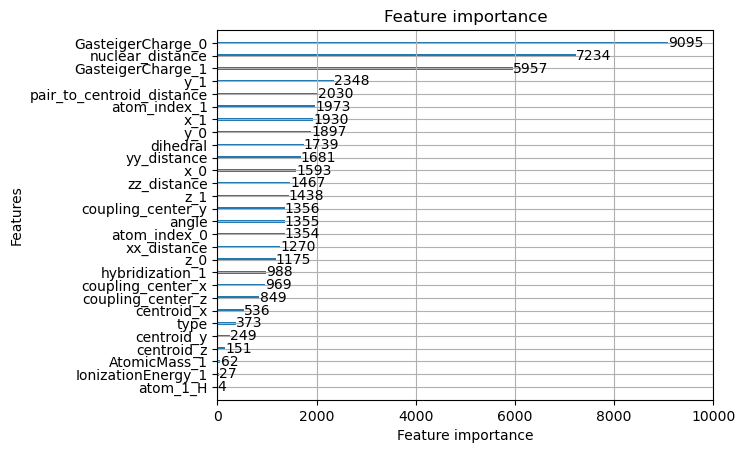

In [ ]:
lgb.plot_importance(fine_tuned_model)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

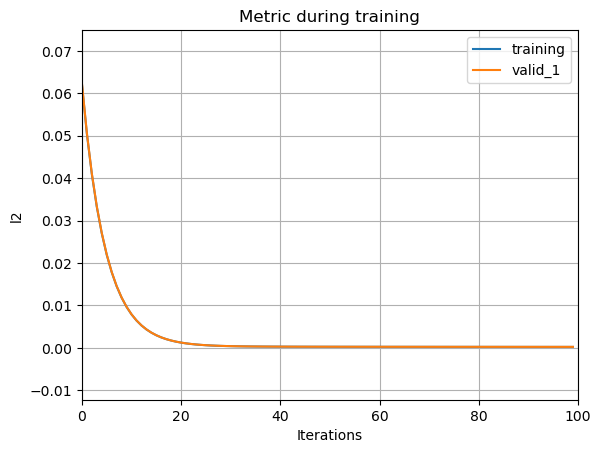

In [ ]:
lgb.plot_metric(eval_results)

In [ ]:
fine_tuned_model = lgb.Booster(model_file=os.path.join(MODEL_FOLDER, "FineTuned_Model.txt"))

y_tuned_preds = fine_tuned_model.predict(X_val)

In [ ]:
X_val.head()

,atom_index_0,atom_index_1,type,x_0,y_0,z_0,AtomicMass_0,Electronegativity_0,AtomicRadius_0,IonizationEnergy_0,...,coupling_center_z,centroid_x,centroid_y,centroid_z,pair_to_centroid_distance,angle,dihedral,atom_1_H,atom_1_N,atom_0_H
139533,8,9,3,0.085177,0.192238,0.062391,-1.0,-1.0,-1.0,-1.0,...,-0.554132,-0.032854,-0.406366,0.291680,-0.583023,0.186089,9.173995e-12,True,False,True
3680658,16,7,5,0.064441,-0.338941,-0.234611,-1.0,-1.0,-1.0,-1.0,...,-2.311371,-0.412019,-0.029473,0.292248,-0.363254,-1.000000,7.086555e-01,False,False,True
2262300,18,7,1,-0.328919,-0.034389,0.251366,-1.0,-1.0,-1.0,-1.0,...,1.387381,-0.170925,0.109730,-0.159614,-0.479885,-1.000000,9.173995e-12,False,True,True
2076515,12,3,2,-0.012790,-0.078728,-0.195056,-1.0,-1.0,-1.0,-1.0,...,-1.352263,-0.184167,0.077388,-0.216110,-0.656085,0.280183,9.173995e-12,False,False,True
346356,13,2,0,0.144862,-0.063431,-0.129712,-1.0,-1.0,-1.0,-1.0,...,-1.352282,0.194054,-0.038951,0.183251,-0.674317,-1.000000,9.173995e-12,False,False,True


In [ ]:
results_df = X_val.copy()
results_df["SCC"] = y_val
results_df["Reference_model_SCC"] = y_reference_preds
results_df["Fine_tuned_model_SCC"] = y_tuned_preds
results_df["type"] = J_type_encoder.inverse_transform(results_df["type"])

results_df.head()

,atom_index_0,atom_index_1,type,x_0,y_0,z_0,AtomicMass_0,Electronegativity_0,AtomicRadius_0,IonizationEnergy_0,...,centroid_z,pair_to_centroid_distance,angle,dihedral,atom_1_H,atom_1_N,atom_0_H,SCC,Reference_model_SCC,Fine_tuned_model_SCC
139533,8,9,2JHH,0.085177,0.192238,0.062391,-1.0,-1.0,-1.0,-1.0,...,0.291680,-0.583023,0.186089,9.173995e-12,True,False,True,-0.741390,-0.740449,-0.741660
3680658,16,7,3JHC,0.064441,-0.338941,-0.234611,-1.0,-1.0,-1.0,-1.0,...,0.292248,-0.363254,-1.000000,7.086555e-01,False,False,True,-0.646850,-0.622747,-0.625791
2262300,18,7,1JHN,-0.328919,-0.034389,0.251366,-1.0,-1.0,-1.0,-1.0,...,-0.159614,-0.479885,-1.000000,9.173995e-12,False,True,True,-0.409968,-0.385791,-0.390032
2076515,12,3,2JHC,-0.012790,-0.078728,-0.195056,-1.0,-1.0,-1.0,-1.0,...,-0.216110,-0.656085,0.280183,9.173995e-12,False,False,True,-0.615478,-0.647803,-0.645986
346356,13,2,1JHC,0.144862,-0.063431,-0.129712,-1.0,-1.0,-1.0,-1.0,...,0.183251,-0.674317,-1.000000,9.173995e-12,False,False,True,0.069073,0.038107,0.044274


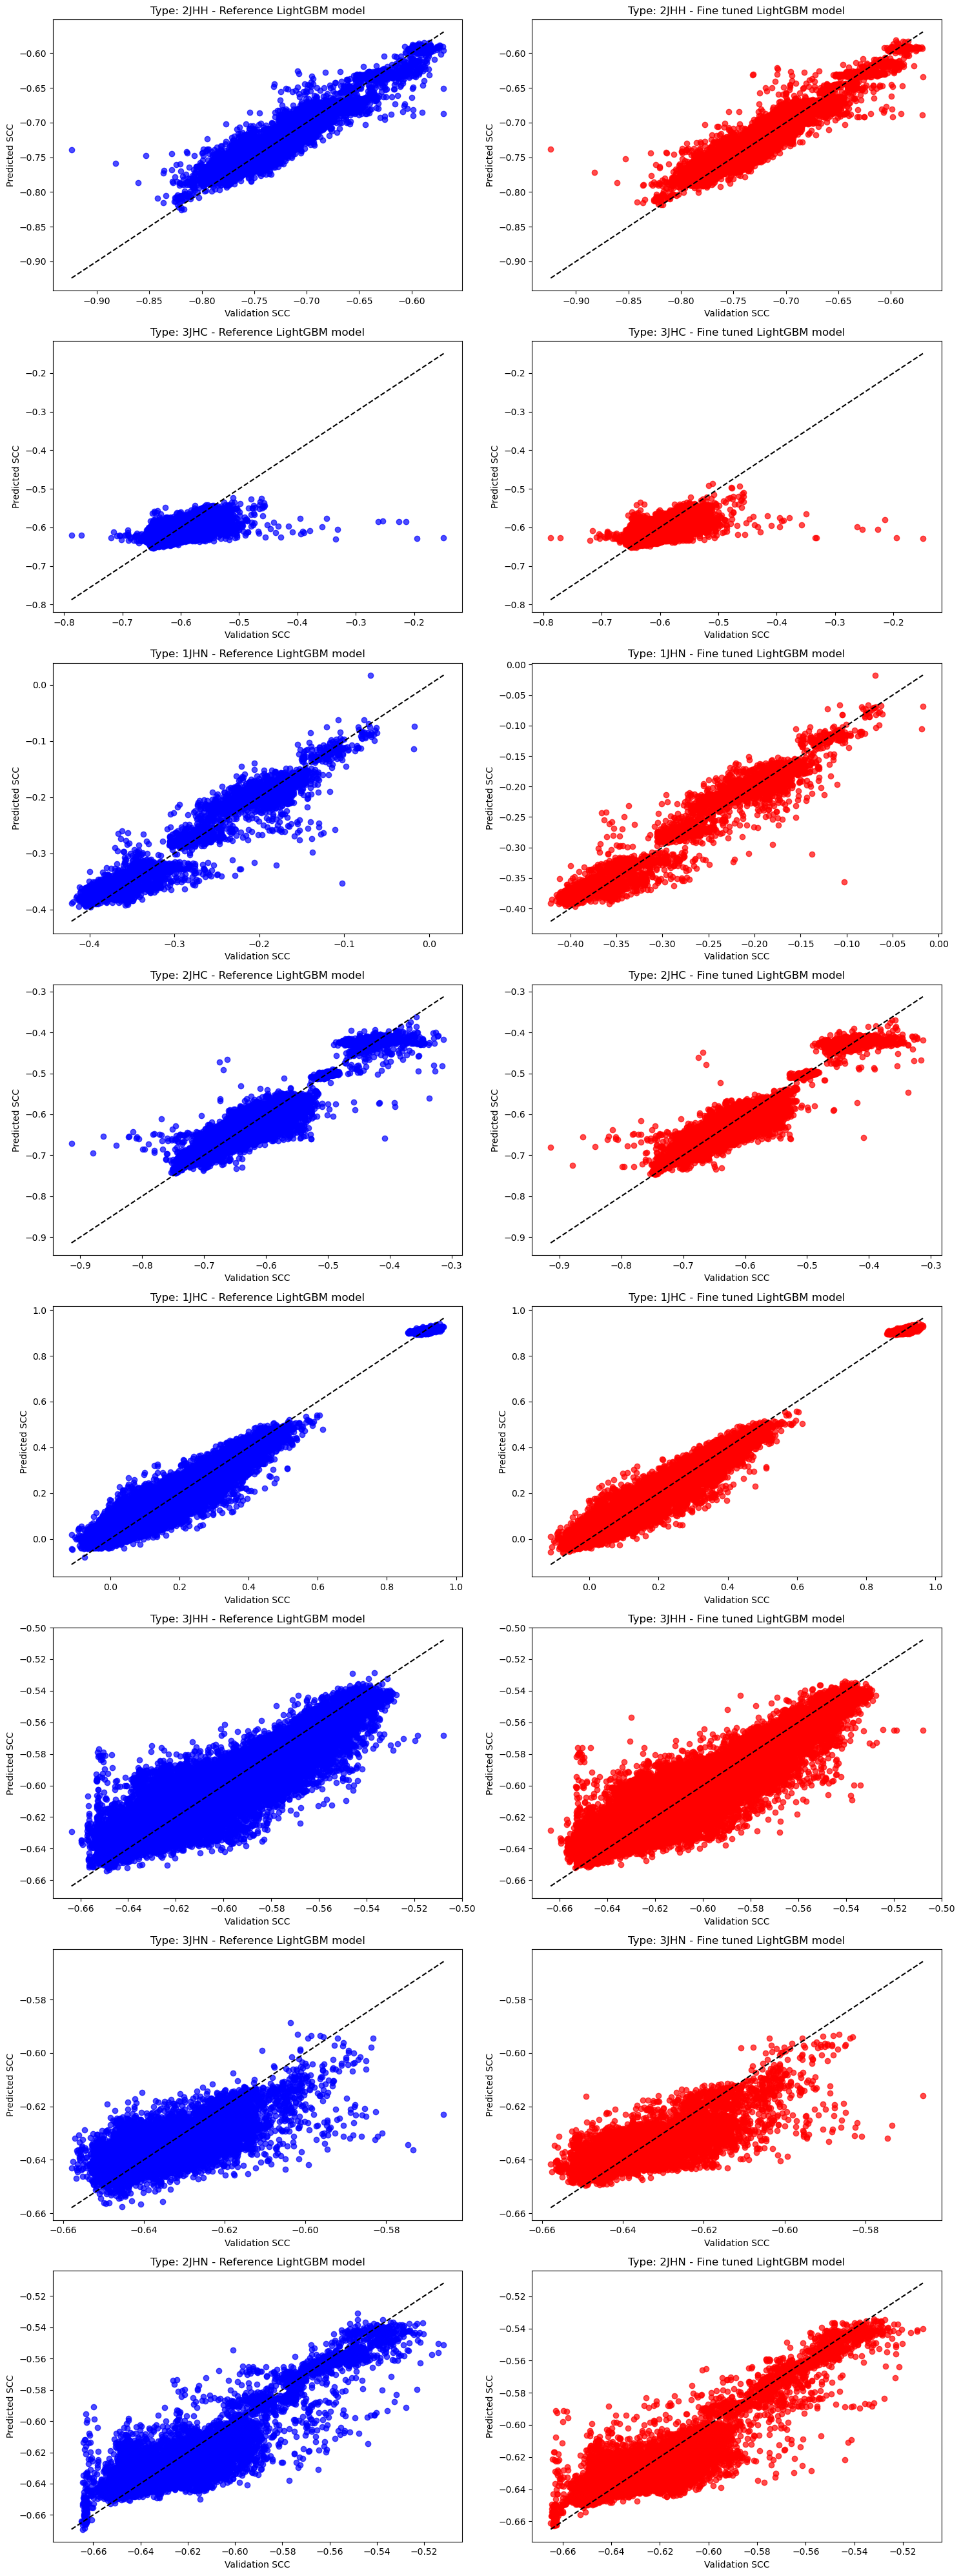

In [ ]:
results_by_type = results_df.groupby("type")

unique_types = results_df["type"].unique()
num_types = len(unique_types)

fig, axes = plt.subplots(nrows=num_types, ncols=num_models, figsize=(15, 5*num_types))

for row, type_name in enumerate(unique_types):
    group = results_df[results_df["type"] == type_name]
    ax1 = axes[row, 0]
    ax1.scatter(group["SCC"], group["Reference_model_SCC"], color='blue', alpha=0.7)
    ax1.set_title(f"Type: {type_name} - Reference LightGBM model")
    ax1.set_xlabel("Validation SCC")
    ax1.set_ylabel("Predicted SCC")

    min_val = min(group["SCC"].min(), group["Reference_model_SCC"].min())
    max_val = max(group["SCC"].max(), group["Reference_model_SCC"].max())
    ax1.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--", label="y = x")

    ax2 = axes[row, 1]
    ax2.scatter(group["SCC"], group["Fine_tuned_model_SCC"], color='red', alpha=0.7)
    ax2.set_title(f"Type: {type_name} - Fine tuned LightGBM model")
    ax2.set_xlabel("Validation SCC")
    ax2.set_ylabel("Predicted SCC")

    min_val = min(group["SCC"].min(), group["Fine_tuned_model_SCC"].min())
    max_val = max(group["SCC"].max(), group["Fine_tuned_model_SCC"].max())
    ax2.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--", label="y = x")

plt.tight_layout()
plt.show()

## Metrics comparison
The leaderboard of the kaggle competition is calculated on
Source: https://www.kaggle.com/code/uberkinder/efficient-metric

In [ ]:
def group_mean_log_mae(y_true, y_pred, groups, floor=1e-9):
    maes = (y_true-y_pred).abs().groupby(groups).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [ ]:
# Reversing the scaling of the data:
results_df["SCC"] = target_scaler.inverse_transform(results_df["SCC"].values.reshape(-1, 1))
results_df["Reference_model_SCC"] = target_scaler.inverse_transform(results_df["Reference_model_SCC"].values.reshape(-1, 1))
results_df["Fine_tuned_model_SCC"] = target_scaler.inverse_transform(results_df["Fine_tuned_model_SCC"].values.reshape(-1, 1))

In [ ]:
reference_mae = mean_absolute_error(results_df["SCC"], results_df["Reference_model_SCC"])
reference_mse = mean_squared_error(results_df["SCC"], results_df["Reference_model_SCC"])

fine_tuned_mae = mean_absolute_error(results_df["SCC"], results_df["Fine_tuned_model_SCC"])
fine_tuned_mse = mean_squared_error(results_df["SCC"], results_df["Fine_tuned_model_SCC"])

In [ ]:
groups = results_df["type"]
y_true = results_df["SCC"]
y_reference_pred = results_df["Reference_model_SCC"]
y_fine_tuned_pred = results_df["Fine_tuned_model_SCC"]

reference_group_mae = group_mean_log_mae(y_true, y_reference_pred, groups)
fine_tuned_group_mae = group_mean_log_mae(y_true, y_fine_tuned_pred, groups)

In [ ]:
models = ["Reference LightGBM", "Fine tuned LightGBM"]
metrics = ["MAE", "MSE", "Grouped log(MAE)"]

data = [[reference_mae, reference_mse, reference_group_mae],
        [fine_tuned_mae, fine_tuned_mse, fine_tuned_group_mae]]

metrics_df = pd.DataFrame(data, columns=metrics, index=models)
metrics_df

,MAE,MSE,Grouped log(MAE)
Reference LightGBM,1.390554,4.560989,0.195981
Fine tuned LightGBM,1.280286,3.902687,0.105092


In [ ]:
## Individual MAE for each group
J_types = results_df["type"].unique()

ref_maes = []
tuned_maes = []
maes = []
for J_type in J_types:
    y_true = results_df[results_df["type"] == J_type]["SCC"]
    y_pred1 = results_df[results_df["type"] == J_type]["Reference_model_SCC"]
    y_pred2 = results_df[results_df["type"] == J_type]["Fine_tuned_model_SCC"]
    ref_maes.append(mean_absolute_error(y_true, y_pred1))
    tuned_maes.append(mean_absolute_error(y_true, y_pred2))

maes.append(ref_maes)
maes.append(tuned_maes)

individual_maes = pd.DataFrame(maes, columns=J_types, index=models)
individual_maes

,2JHH,3JHC,1JHN,2JHC,1JHC,3JHH,3JHN,2JHN
Reference LightGBM,0.754309,1.303848,2.254126,1.232822,2.725749,0.917112,0.624374,1.124347
Fine tuned LightGBM,0.703894,1.214707,1.990330,1.172738,2.449684,0.812702,0.575120,1.014426
